# Error bars: the ``Profiler``
Taking a fully Bayesian approach to MSD inference allows us to calculate reliable error bars on the fit results.

## Initial example

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import bayesmsd

np.random.seed(113756719)

We generate data from the powerlaw $\text{MSD}(\Delta t) = (\Delta t)^{0.63}$ and fit it with ``bayesmsd.lib.NPXFit``; so we are hoping to recover the parameter values $\Gamma = 1$ and $\alpha = 0.63$. We run the fit & profiler for increasing numbers of trajectories in the dataset (between 1 and 20 trajectories); clearly with more data we should get more precise estimates.

In [2]:
@bayesmsd.deco.MSDfun
def msd(dt):
    return dt**0.63

out = []
for n_traj in tqdm([1, 2, 5, 10, 20]):
    data = bayesmsd.gp.generate((msd, 1, 1), T=100, n=n_traj)
    
    fit = bayesmsd.lib.NPXFit(data, ss_order=1)
    fit.parameters['log(σ²) (dim 0)'].fix_to = -np.inf
    
    profiler = bayesmsd.Profiler(fit)
    mci = profiler.find_MCI()
    
    out.append((n_traj, mci))

Reformat the outputs and plot them:

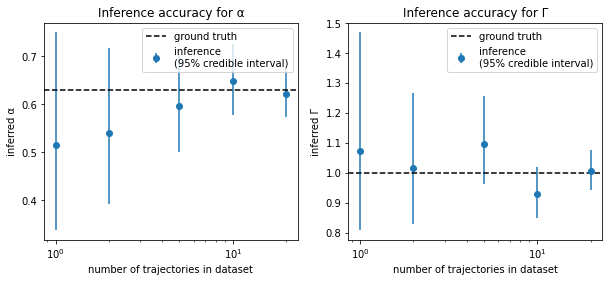

In [3]:
# Reformat
n    =        np.array([n_traj                   for n_traj, mci in out])
G_pe = np.exp(np.array([mci['log(Γ) (dim 0)'][0] for n_traj, mci in out]))
G_ci = np.exp(np.array([mci['log(Γ) (dim 0)'][1] for n_traj, mci in out]))
a_pe =        np.array([mci['α (dim 0)'     ][0] for n_traj, mci in out])
a_ci =        np.array([mci['α (dim 0)'     ][1] for n_traj, mci in out])

# Plot
fig, axs = plt.subplots(1, 2, figsize=[10, 4])

for (pe, ci,
     name, true_value,
     ax,
    ) in zip([a_pe, G_pe], [a_ci, G_ci],
             ['α', 'Γ'], [0.63, 1.00],
             axs,
            ):
    ax.axhline(true_value, linestyle='--', color='k', label='ground truth')
    ax.errorbar(n, pe, yerr=np.abs(ci.T - pe[None, :]),
                linestyle='', marker='o',
                label='inference\n(95% credible interval)',
               )

    ax.legend()
    ax.set_xlabel('number of trajectories in dataset')
    ax.set_ylabel(f'inferred {name}')
    ax.set_xscale('log')
    ax.set_title(f'Inference accuracy for {name}')
    
plt.show()

As expected, the point estimates become better with increasing amounts of data. Crucially though, we also know how imprecise the estimates are for, e.g., a single trajectory! Note that the 95% credible interval covers the true parameter value in most cases: the fit might be off, but at least we can gauge by how much we might be off. This provision of reliable error estimates is a core strength of ``bayesmsd``.

## Usage
Using the ``Profiler`` is relatively simple, as illustrated above. On initialization it takes a ``Fit`` object, which contains the data and definition of the fit model. Beyond that you can tweak a few settings, like the confidence level (95% by default), the verbosity (how much output is printed while running), or whether to use profile likelihoods (``profiling = True``) or marginal likelihoods (``profiling = False``).

Once the profiler is set up with all that information, you just have to call its ``find_MCI()`` method to let it run. This method returns a dict containing, for each parameter of the fit, the point estimate and 95% credible interval. By default, ``find_MCI()`` calculates intervals for all parameters; you can use the ``parameters = <list of names>`` keyword argument to restrict the computation to a select subset.

## Internal workings
While running the profiler requires just two lines of code, internally of course there is a bit more to it. Here is a rundown of what the profiler does upon execution of ``find_MCI()``:

 #. Get a point estimate. This just means running an initial fit, like you would do manually. If, in fact, you did run the fit already before initializing the profiler, you can just set ``profiler.point_estimate`` to the fit result, so the profiler won't run the same fit again (c.f. [Quickstart](00_intro.ipynb)).
 #. Start the profiling runs for the individual parameters. It is possible that during this more rigorous exploration of the posterior we come across a better point estimate than what the ``Fit`` found initially (e.g. if the likelihood landscape is sufficiently rugged). In that case, the profiler starts over completely, using that new point estimate as inital conditions.
 #. Now, for each parameter we walk along the profile likelihood until it decreases below a threshold (dependent on the desired credibility level). How these steps are taken is determined by the ``linearization`` attribute of each parameter, as described [here](01_parameters.ipynb#Advanced:-linearization).
 #. Having found a point below the threshold, we now have a "bracket" enclosing the desired bound of the credible interval (which is the point exactly *at* the threshold): the point estimate is certainly above, while the point we just found is below. We can therefore now solve the problem to given precision (c.f. ``Profiler.conf_precision``) by bisection, which converges exponentially.
 #. Repeat by walking in the other direction from the point estimate
 
By running through these steps for all parameters successively, the ``Profiler`` finds the interval boundaries where the profile likelihood (or marginal likelihood, if ``profiling = False``) decreases by a given amount from the maximum (the point estimate). These are the credible intervals for each parameter.